# Перевод с испанского на английский с помощью модели sequence-to-sequence Transformer

## Introduction

Рассмотрим простейшую реализацию модели Transformer, адаптированную из книги [Deep Learning with Python, Second Edition (chapter 11: Deep learning for text)](https://www.piter.com/collection/programmirovanie-osnovy-i-algoritmy/product/glubokoe-obuchenie-na-python-2-e-mezhd-izdanie).

## Загрузка необходимых библиотек и модулей

In [ ]:

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import pathlib
import random
import string
import re
import numpy as np

import tensorflow.data as tf_data
import tensorflow.strings as tf_strings

import keras
from keras import layers
from keras import ops
from keras.layers import TextVectorization

In [ ]:
import pandas as pd

## Загрузка данных

Мы будем работать с набором данных для перевода с испанского на английский, предоставленным компанией [Anki](https://www.manythings.org/anki/).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Анализ и подготовка данных

Каждая строка содержит английское предложение и соответствующее ему предложение на испанском языке. Испанское предложение является исходной последовательностью, а английское - целевой. Мы добавляем к английскому предложению символ `[начало]` и символ `[конец]`.

In [ ]:
with open('/content/drive/MyDrive/da/fra.txt', 'r', encoding='utf-8') as df:
    path_to_file1= df.read()

In [ ]:
lines = path_to_file1.split("\n")[:-1]

In [ ]:
lines[0]

'Go.\tVa !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)'

In [ ]:
pairs = [line.split('\t') for line in lines]

In [ ]:
pairs[4][0]

'Hi.'

In [ ]:
df=pd.DataFrame(pairs)

In [ ]:
df=df.drop(columns=2)

In [ ]:
pairs=df.reset_index(drop=True).values.tolist()

In [ ]:
text_pairs = []
for i in range(len(pairs)):
  spa=pairs[i][1]
  eng=pairs[i][0]
  eng = "[start] " + eng + " [end]"
  text_pairs.append((spa, eng))

In [ ]:
text_pairs

[('Va !', '[start] Go. [end]'),
 ('Marche.', '[start] Go. [end]'),
 ('En route !', '[start] Go. [end]'),
 ('Bouge !', '[start] Go. [end]'),
 ('Salut !', '[start] Hi. [end]'),
 ('Salut.', '[start] Hi. [end]'),
 ('Cours\u202f!', '[start] Run! [end]'),
 ('Courez\u202f!', '[start] Run! [end]'),
 ('Prenez vos jambes à vos cous !', '[start] Run! [end]'),
 ('File !', '[start] Run! [end]'),
 ('Filez !', '[start] Run! [end]'),
 ('Cours !', '[start] Run! [end]'),
 ('Fuyez !', '[start] Run! [end]'),
 ('Fuyons !', '[start] Run! [end]'),
 ('Cours\u202f!', '[start] Run. [end]'),
 ('Courez\u202f!', '[start] Run. [end]'),
 ('Prenez vos jambes à vos cous !', '[start] Run. [end]'),
 ('File !', '[start] Run. [end]'),
 ('Filez !', '[start] Run. [end]'),
 ('Cours !', '[start] Run. [end]'),
 ('Fuyez !', '[start] Run. [end]'),
 ('Fuyons !', '[start] Run. [end]'),
 ('Qui ?', '[start] Who? [end]'),
 ('Ça alors\u202f!', '[start] Wow! [end]'),
 ('Waouh\xa0!', '[start] Wow! [end]'),
 ('Wah\xa0!', '[start] Wow! [e

Посмотрим, как выглядят сформированные пары предложений.

In [ ]:
for _ in range(5):
    print(random.choice(text_pairs))

('Je ne devrais pas être ici.', "[start] I shouldn't be here. [end]")
("Je t'aime !", '[start] I love you. [end]')
("J'espère que tu ne fais pas cela.", "[start] I hope you don't do that. [end]")
("Je ne me sens pas bien et j'aimerais rester à la maison aujourd'hui.", "[start] I'm not feeling well and would like to stay home today. [end]")
('Je me sens presque désolé pour toi.', '[start] I almost feel sorry for you. [end]')


Теперь разделим все пары предложений на обучающий набор, валидационный набор и тестовый набор.

In [ ]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

232736 total pairs
162916 training pairs
34910 validation pairs
34910 test pairs


## Векторизация текстовых данных

Мы будем использовать два экземпляра слоя `TextVectorization` для векторизации текстовых данных (один для английского и один для испанского языков), то есть для преобразования исходных строк в целочисленные последовательности, где каждое целое число представляет индекс слова в словаре.

В английском слое будет использоваться стандартизация строк по умолчанию (удаление знаков препинания) и схема разделения (разделение на пробелы), в то время как в испанском слое будет использоваться пользовательская стандартизация, где мы добавим символ "¿" к набору символов препинания, которые нужно удалить.

**Примечание:** в модели машинного перевода, используемой в производственных условиях, не рекомендуют удалять знаки препинания ни на одном из языков. Вместо этого преобразовают каждый знак препинания в отдельный токен. Этого можно добиться испольванием пользовательской функции разделения на уровне векторизации текста.

In [ ]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 20000
sequence_length = 20
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf_strings.lower(input_string)
    return tf_strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


spa_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
    standardize=custom_standardization,
)

eng_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
)

train_spa_texts = [pair[0] for pair in train_pairs]
train_eng_texts = [pair[1] for pair in train_pairs]

spa_vectorization.adapt(train_spa_texts)
eng_vectorization.adapt(train_eng_texts)


Далее отформатируем наши наборы данных.

На каждом этапе обучения модель будет пытаться предсказать целевые слова `N+1` (и далее), используя исходное предложение и целевые слова от 0 до `N`.

Таким образом, набор обучающих данных будет содержать кортеж (входные данные, целевые объекты), где:

* `inputs` - это словарь с ключами `encoder_inputs` и `decoder_inputs`. `encoder_inputs` - это векторизованное исходное предложение, а `encoder_inputs` - это целевое предложение "до сих пор", то есть слова от 0 до `N`, используемые для предсказания слова `N`+1 (и далее) в целевом предложении.
* `target` – это целевое предложение, смещенное на один шаг: оно содержит следующие слова в целевом предложении - то, что модель попытается предсказать.

In [ ]:
def format_dataset(spa, eng):
    spa = spa_vectorization(spa)
    eng = eng_vectorization(eng)

    return (
        {
            "encoder_inputs": spa,
            "decoder_inputs": eng[:, :-1],
        },
        eng[:, 1:],
    )


def make_dataset(pairs):
    spa_texts,  eng_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf_data.Dataset.from_tensor_slices((spa_texts, eng_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.cache().shuffle(2048).prefetch(16)


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

Рассмотрим формы последовательности (у нас есть наборы из 64 пар, и все последовательности состоят из 20 предложений).

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


## Построение модели

Модель sequence-to-sequence Transformer состоит из TransformerEncoder и TransformerDecoder, соединенных вместе. Чтобы модель учитывала порядок слов, мы также используем слой PositionalEmbedding (позиционного встраивания).

Исходная последовательность передается в TransformerEncoder, который создает новое представление. Это новое представление затем передается в TransformerDecoder вместе с целевой последовательностью на данный момент (целевые слова от 0 до N). Затем TransformerDecoder попытается предсказать следующие слова в целевой последовательности (N+1 и далее).

Ключевой деталью, которая делает это возможным, является причинное маскирование (см. метод get_causal_attention_mask() в TransformerDecoder). Transformer Decoder видит все последовательности сразу, и поэтому необходимо убедиться, что он использует только информацию от целевых токенов от 0 до N при прогнозировании токена N+1 (в противном случае он мог бы использовать информацию из будущего, что приводит к модели, которую нельзя использовать во время вывода).

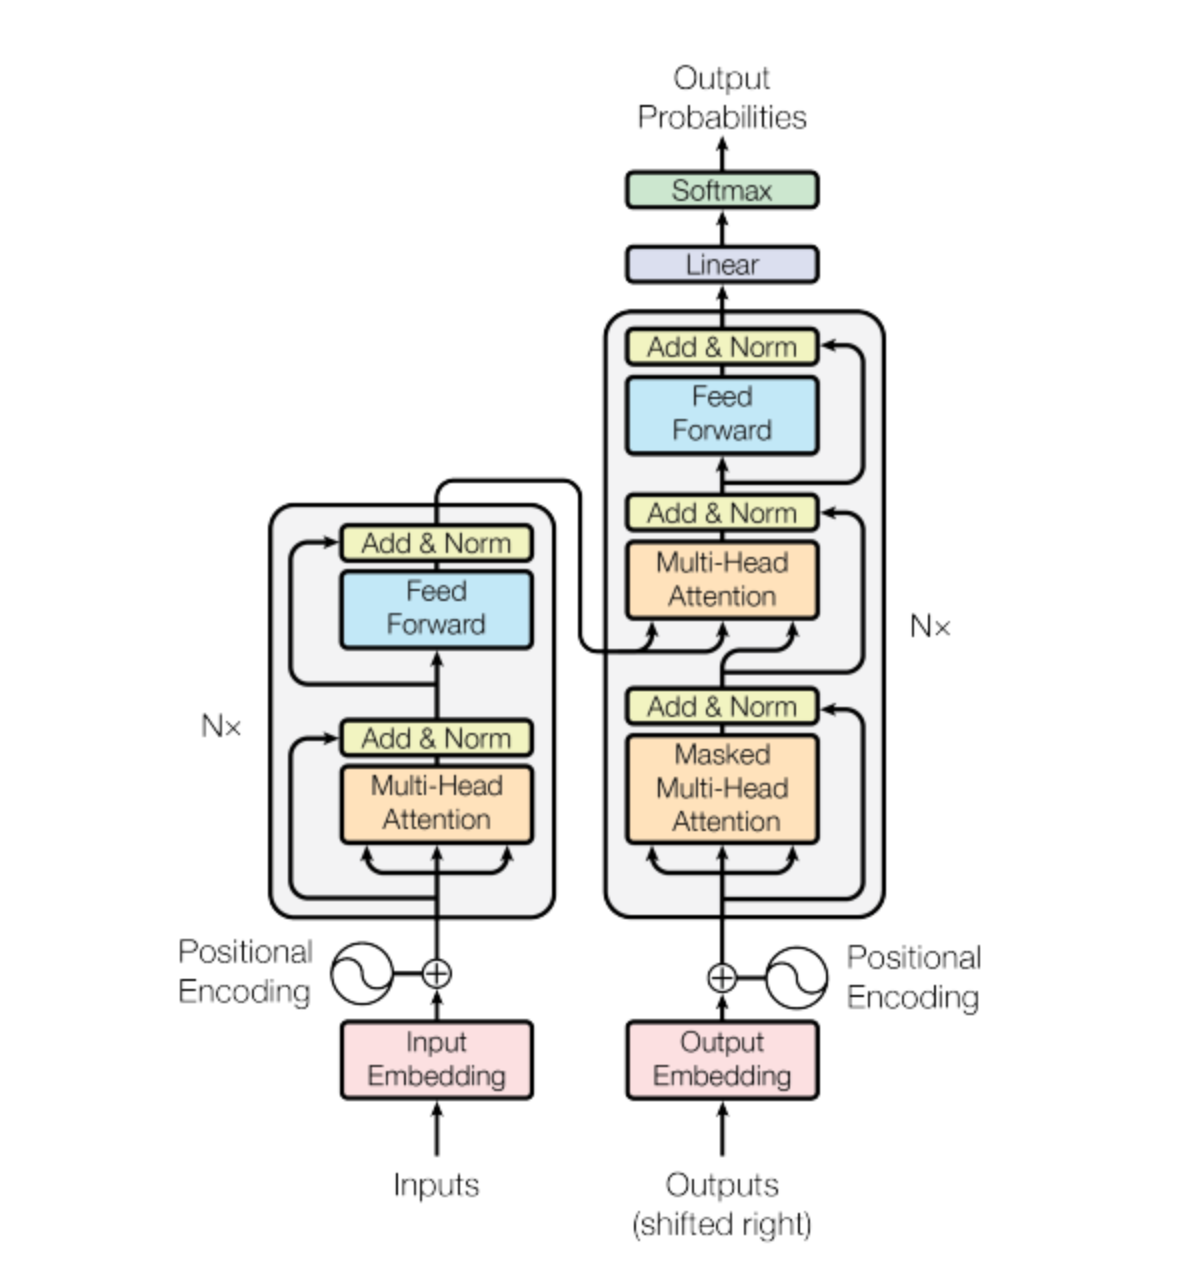

### TransformerEncoder

In [ ]:
import keras.ops as ops


class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
        else:
            padding_mask = None

        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "dense_dim": self.dense_dim,
                "num_heads": self.num_heads,
            }
        )
        return config




### Позиционное кодирование

Слои внимания видят свои входные данные как набор векторов без учета порядка в последовательности. Эта модель не содержит рекуррентных или сверточных слоев. Из-за этого добавляется «позиционное кодирование», чтобы дать модели некоторую информацию об относительном положении токенов в предложении.

Вектор позиционного кодирования добавляется к вектору встраивания. Вложения представляют токен в d-мерном пространстве, где токены со схожим значением будут ближе друг к другу. Но вложения не кодируют относительное положение токенов в предложении. Таким образом, после добавления позиционного кодирования токены будут ближе друг к другу на основе схожести их значения и их положения в предложении , в d-мерном пространстве.

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = ops.shape(inputs)[-1]
        positions = ops.arange(0, length, 1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        if mask is None:
            return None
        else:
            return ops.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config




### TransformerDecoder

In [ ]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
            padding_mask = ops.minimum(padding_mask, causal_mask)
        else:
            padding_mask = None

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = ops.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = ops.arange(sequence_length)[:, None]
        j = ops.arange(sequence_length)
        mask = ops.cast(i >= j, dtype="int32")
        mask = ops.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = ops.concatenate(
            [ops.expand_dims(batch_size, -1), ops.convert_to_tensor([1, 1])],
            axis=0,
        )
        return ops.tile(mask, mult)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "latent_dim": self.latent_dim,
                "num_heads": self.num_heads,
            }
        )
        return config


Теперь собираем модель.

In [ ]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)


## Обучение модели

Для быстрого отслеживания прогресса обучения на основе валидационных данных будем использовать `accuracy`. Обратите внимание, что при машинном переводе обычно используются оценки [`BLEU`](https://www.digitalocean.com/community/tutorials/bleu-score-in-python) и другие показатели, а не `accuracy`.

Процесс обучения проведем на 30 эпохах.



In [ ]:
epochs = 30

transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)




Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_embedding      │ (None, None, 256)      │      5,125,120 │ encoder_inputs[0][0]   │
│ (PositionalEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder       │ (None, None, 256)      │      3,155,456 │ positional_embedding[… │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_3 (Functional) │ (None, None, 20000)    │     15,524,640 │ decoder_inputs[0][0],  │
│                           │                        │                │ transformer_encoder[0… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,805,216 (90.81 MB)

 Trainable params: 23,805,216 (90.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
2546/2546 ━━━━━━━━━━━━━━━━━━━━ 177s 63ms/step - accuracy: 0.7261 - loss: 1.9582 - val_accuracy: 0.7984 - val_loss: 1.2662
Epoch 2/30
2546/2546 ━━━━━━━━━━━━━━━━━━━━ 145s 57ms/step - accuracy: 0.8607 - loss: 0.8966 - val_accuracy: 0.9879 - val_loss: 0.1151
Epoch 3/30
2546/2546 ━━━━━━━━━━━━━━━━━━━━ 143s 56ms/step - accuracy: 0.9874 - loss: 0.1097 - val_accuracy: 0.9942 - val_loss: 0.0612
Epoch 4/30
2546/2546 ━━━━━━━━━━━━━━━━━━━━ 200s 55ms/step - accuracy: 0.9941 - loss: 0.0533 - val_accuracy: 0.9962 - val_loss: 0.0424
Epoch 5/30
2546/2546 ━━━━━━━━━━━━━━━━━━━━ 142s 56ms/step - accuracy: 0.9965 - loss: 0.0321 - val_accuracy: 0.9970 - val_loss: 0.0332
Epoch 6/30
2546/2546 ━━━━━━━━━━━━━━━━━━━━ 141s 56ms/step - accuracy: 0.9972 - loss: 0.0264 - val_accuracy: 0.9975 - val_loss: 0.0280
Epoch 7/30
2546/2546 ━━━━━━━━━━━━━━━━━━━━ 139s 55ms/step - accuracy: 0.9983 - loss: 0.0153 - val_accuracy: 0.9981 - val_loss: 0.0249
Epoch 8/30
2546/2546 ━━━━━━━━━━━━━━━━━━━━ 141s 55ms/step - accuracy: 

## Decoding (перевод) тестовых предложений

Для перевода новых английских предложений нужно ввести в модель векторизованное английское предложение, а также целевой токен `[start]`, затем повторно сгенерировать следующий токен, пока не достигнем токена `[end]`.


In [ ]:
eng_vocab = eng_vectorization.get_vocabulary()
eng_index_lookup = dict(zip(range(len(eng_vocab)), eng_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = spa_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = eng_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        # ops.argmax(predictions[0, i, :]) is not a concrete value for jax here
        sampled_token_index = ops.convert_to_numpy(
            ops.argmax(predictions[0, i, :])
        ).item(0)
        sampled_token = eng_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence




In [ ]:
test_spa_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_spa_texts)
    translated = decode_sequence(input_sentence)
    print(input_sentence, translated)



Que serait la vie sans espoir ? [start] sister a nothing theres lies               
Voici une rose jaune. [start] he brain essential                 
On va te protéger. [start] something with rice                 
Ça semble tellement simple avec toi. [start] name meeting beginning how see               
Il a gloussé. [start] dont insured                  
Je n'étais pas d'humeur à cuisiner. [start] vacation i rising tom birds               
Je suis vraiment désolé pour ce qui s'est passé. [start] my would looks for in like please ask            
Elle peut à peine parler. [start] talk tom marys should                
Je ne savais pas que tu serais là. [start] to read i you it taking lets             
Tom a vu Mary. [start] dont whats any                 
Pensez-vous que je devrais demander de l'aide à Tom ? [start] you start understand anybody end whose tom that            
Je ne veux pas être choisi. [start] to youre i will rope               
Viens rencontrer tout le monde ! [start] c

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
num=[400,1479,29562,6426,30658,17580,6840,34678,21544,5830]
pairs2=[]
for i in range(10):
  #print(num[i])
  pairs2.append(test_pairs[num[i]])
pairs2

[('Vous êtes fort drôle.', "[start] You're very funny. [end]"),
 ("Elle ne voulait pas qu'il restât plus longtemps.",
  "[start] She didn't want him to stay any longer. [end]"),
 ('Tire la langue !', '[start] Stick out your tongue. [end]'),
 ('Je lui ai donné le livre.', '[start] I gave him the book. [end]'),
 ('Elle chantait en marchant.', '[start] She sang as she walked. [end]'),
 ('Il faut que tu te battes !', '[start] You have to fight. [end]'),
 ('Ne vous en faites pas. Je suis bon là-dedans.',
  "[start] Don't worry. I'm good at this. [end]"),
 ('Nous prévoyons de demander une extension.',
  "[start] We're planning to apply for an extension. [end]"),
 ('Vous ne seriez pas capable de gérer la pression.',
  "[start] You wouldn't be able to handle the pressure. [end]"),
 ('Parfois, je ne te comprends pas.',
  "[start] Sometimes I don't get you. [end]")]

In [ ]:
est_eng_texts = [pair[1] for pair in pairs2]
est_eng_texts

["[start] You're very funny. [end]",
 "[start] She didn't want him to stay any longer. [end]",
 '[start] Stick out your tongue. [end]',
 '[start] I gave him the book. [end]',
 '[start] She sang as she walked. [end]',
 '[start] You have to fight. [end]',
 "[start] Don't worry. I'm good at this. [end]",
 "[start] We're planning to apply for an extension. [end]",
 "[start] You wouldn't be able to handle the pressure. [end]",
 "[start] Sometimes I don't get you. [end]"]

In [ ]:
pairs = [line.split(' ') for line in est_eng_texts]

In [ ]:
pairs1 = [line.remove('[start]') for line in pairs]

In [ ]:
pairs1 = [line.remove('[end]') for line in pairs]

In [ ]:
(pairs)

[["You're", 'very', 'funny.'],
 ['She', "didn't", 'want', 'him', 'to', 'stay', 'any', 'longer.'],
 ['Stick', 'out', 'your', 'tongue.'],
 ['I', 'gave', 'him', 'the', 'book.'],
 ['She', 'sang', 'as', 'she', 'walked.'],
 ['You', 'have', 'to', 'fight.'],
 ["Don't", 'worry.', "I'm", 'good', 'at', 'this.'],
 ["We're", 'planning', 'to', 'apply', 'for', 'an', 'extension.'],
 ['You', "wouldn't", 'be', 'able', 'to', 'handle', 'the', 'pressure.'],
 ['Sometimes', 'I', "don't", 'get', 'you.']]

In [ ]:
est_spa_texts = [pair[0] for pair in pairs2]
est_spa_texts

['Vous êtes fort drôle.',
 "Elle ne voulait pas qu'il restât plus longtemps.",
 'Tire la langue !',
 'Je lui ai donné le livre.',
 'Elle chantait en marchant.',
 'Il faut que tu te battes !',
 'Ne vous en faites pas. Je suis bon là-dedans.',
 'Nous prévoyons de demander une extension.',
 'Vous ne seriez pas capable de gérer la pression.',
 'Parfois, je ne te comprends pas.']

In [ ]:
est_spa_texts[1]

"Elle ne voulait pas qu'il restât plus longtemps."

In [ ]:
#test_spa_texts = [pair[0] for pair in test_pairs]
predict=[]
for i in range(10):
    input_sentence = est_spa_texts[i]
    translated = decode_sequence(input_sentence)
    predict.append(translated)
    print(input_sentence, translated)


Vous êtes fort drôle. [start] us while twice                 
Elle ne voulait pas qu'il restât plus longtemps. [start] to such i and rehearsals be children             
Tire la langue ! [start] a then                  
Je lui ai donné le livre. [start] so doing mine the may               
Elle chantait en marchant. [start] smartphone was prevents                 
Il faut que tu te battes ! [start] car you it with studio               
Ne vous en faites pas. Je suis bon là-dedans. [start] is was those i start my doesnt covered            
Nous prévoyons de demander une extension. [start] ballpoint end anybody he studio               
Vous ne seriez pas capable de gérer la pression. [start] to younger i dance end grew a wondered            
Parfois, je ne te comprends pas. [start] start to with questions i               


In [ ]:
predict

['[start] us while twice',
 '[start] to such i and rehearsals be children',
 '[start] a then',
 '[start] so doing mine the may',
 '[start] smartphone was prevents',
 '[start] car you it with studio',
 '[start] is was those i start my doesnt covered',
 '[start] ballpoint end anybody he studio',
 '[start] to younger i dance end grew a wondered',
 '[start] start to with questions i']

In [ ]:
pairs3

[['us', 'while', 'twice'],
 ['to', 'such', 'i', 'and', 'rehearsals', 'be', 'children'],
 ['a', 'then'],
 ['so', 'doing', 'mine', 'the', 'may'],
 ['smartphone', 'was', 'prevents'],
 ['car', 'you', 'it', 'with', 'studio'],
 ['is', 'was', 'those', 'i', 'start', 'my', 'doesnt', 'covered'],
 ['ballpoint', 'end', 'anybody', 'he', 'studio'],
 ['to', 'younger', 'i', 'dance', 'end', 'grew', 'a', 'wondered'],
 ['start', 'to', 'with', 'questions', 'i']]

In [ ]:
for i in range(len(predict)):
    predict[i]=predict[i].strip()

In [ ]:
pairs3 = [line.split(' ') for line in predict]

In [ ]:
pairs4 = [line.remove('[start]') for line in pairs3]
pairs4

[None, None, None, None, None, None, None, None, None, None]

In [ ]:
for i in range(10):
  print(sentence_bleu(pairs[i], pairs3[i]))

0
1.1200407237786664e-231
0
0
0
0
1.0832677820940877e-231
0
1.0832677820940877e-231
1.2183324802375697e-231


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
bleu_score_corpus = corpus_bleu(pairs, pairs3)

In [ ]:
bleu_score_corpus

9.641193013181824e-232